KNN
decisiion tree normal bagging random forest 
svm all three 

# Iteration 1: KNN Classifier with GridSearchCV and Evaluation

In [2]:
import pandas as pd
import numpy as np
import random


df = pd.read_csv('cleaned_course_difficulty_dataset.csv')
df.describe()

course_rating  assignments_per_week  attendance_required  \
count   49516.000000          49516.000000         49516.000000   
mean        0.029959              0.164506            -0.494769   
std         0.622675              0.566850             0.499978   
min        -0.764706             -0.666667            -1.000000   
25%        -0.529412             -0.333333            -1.000000   
50%         0.000000              0.000000             0.000000   
75%         0.470588              0.666667             0.000000   
max         1.588235              1.000000             0.000000   

       sentiment_score         units  hours_per_week      projects  \
count     49516.000000  49516.000000    49516.000000  49516.000000   
mean          0.059997     -0.225079       -0.100254     -0.499091   
std           0.599905      0.534907        0.670677      0.500004   
min          -0.693069     -1.000000       -1.800000     -1.000000   
25%          -0.495050     -1.000000       -0.600000     -1.000000   
50%           0.000000      0.000000        0.000000      0.000000   
75%           0.504950      0.000000        0.400000      0.000000   
max           1.287129      0.500000        7.800000      0.000000   

       midterms_count    final_exam  grading_strictness  failure_rate  \
count    49516.000000  49516.000000        49516.000000  49516.000000   
mean         0.000596     -0.499152            0.003430     -0.042682   
std          0.407276      0.500004            0.582837      0.701538   
min         -0.500000     -1.000000           -1.000000     -2.000000   
25%         -0.500000     -1.000000           -0.500000     -0.538462   
50%          0.000000      0.000000            0.000000      0.000000   
75%          0.500000      0.000000            0.500000      0.461538   
max          0.500000      0.000000            5.400000      1.076923   

       difficulty_level_num  effort_score  
count          49516.000000  49516.000000  
mean               0.900335     -0.070219  
std                0.700300      0.667332  
min                0.000000     -1.422743  
25%                0.000000     -0.558824  
50%                1.000000      0.000000  
75%                1.000000      0.441176  
max                2.000000      1.281355

In [8]:

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


# Prepare data (assuming df_fe is already scaled and clean)
X = df.drop(columns=['difficulty_level_num'])
y = df['difficulty_level_num']

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Apply PCA
pca = PCA(n_components=12)
X_pca = pca.fit_transform(X)

explained_variance = np.sum(pca.explained_variance_ratio_)
print(explained_variance)
# Then split PCA-reduced data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

0.993113205141767


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Define parameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 13, 15, 20, 30, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

# Grid search with cross-validation
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)


In [ ]:
results_df = pd.DataFrame(grid_search.cv_results_)
print("Grid Search Results:")
display(results_df[['param_n_neighbors', 'param_weights', 'mean_test_score', 'std_test_score']])


# Best model
best_knn = grid_search.best_estimator_
print("Best KNN configuration:", grid_search.best_params_)

# Evaluate on test set
y_pred = best_knn.predict(X_test)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - KNN (Best Model)")
plt.show()

# Cross-validation accuracy
cv_score = cross_val_score(best_knn, X, y_encoded, cv=5, scoring='accuracy')
print(f"Cross-validated Accuracy: {cv_score.mean():.4f} ± {cv_score.std():.4f}")

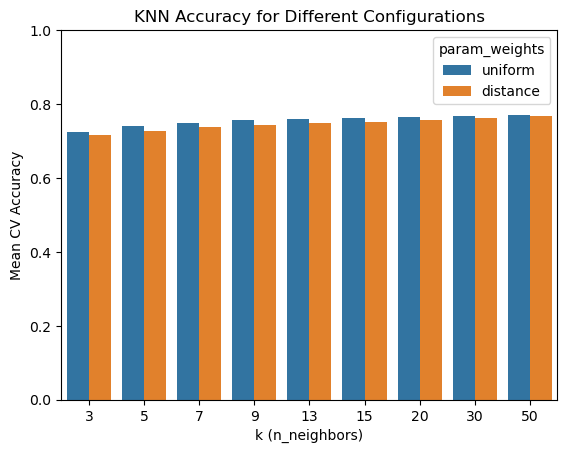

In [137]:
import seaborn as sns
import pandas as pd

# Pull grid search results
results = pd.DataFrame(grid_search.cv_results_)
sns.barplot(data=results, x='param_n_neighbors', y='mean_test_score', hue='param_weights')
plt.title("KNN Accuracy for Different Configurations")
plt.ylabel("Mean CV Accuracy")
plt.xlabel("k (n_neighbors)")
plt.ylim(0, 1)
plt.show()


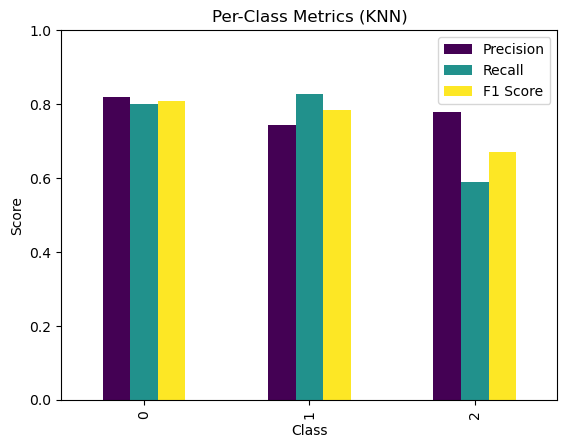

In [138]:
from sklearn.metrics import precision_recall_fscore_support

labels = le.classes_
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Class': labels,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})
metrics_df.set_index('Class').plot(kind='bar', ylim=(0,1), title="Per-Class Metrics (KNN)", colormap="viridis")
plt.ylabel("Score")
plt.show()


In [12]:
#Create a custom color map
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'blue'])
cmap_clear = ListedColormap(['orange', 'lightgray', 'lime'])
cmap_two_clear = ListedColormap(['orange', 'lime'])

# to plot a colorbar, kinda convoluted here!
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_decision_regions(X, Y, estimator, x1=0, x2=1, title='',
                          my_cmap=cmap_clear, size=(14,8), data=True, clf=True):
    '''
    X: Array of (all) feature data 
    Y: Array of labels
    estimator: classifier (e.g., DT) or regressor trained on the feature pair (x1, x2)
    x1, x2: integers, index of the two features selected for plotting the decision region
    title: title of the plot (e.g., it might include the accuracy of the classifier)
    my_cmap: the colormap used to display label colors
    size: size of the figure, in matplotlib
    data: if True, the traiuning datapoints are shown together with the decision regions
    clf: if True, estimator is a classifier, a regressor otherwise
    '''
    
    # get feature ranges for creating a meshgrid
    feature_ranges = np.array([ (np.floor(np.min(X[:, i])), 
                                 np.ceil(np.max(X[:, i]))) 
                                 for i in [x1, x2]]  )

    num_of_pts = 1000
    
    # a meshgrid of values for (f1, f2), these are the points where 
    # algorithm will be queried and that we want to visualize
    xx, yy = np.meshgrid( np.linspace(feature_ranges[0, 0],
                                      feature_ranges[0, 1], 
                                      num=num_of_pts),
                          np.linspace(feature_ranges[1, 0],
                                      feature_ranges[1, 1], 
                                      num=num_of_pts))
    #print(xx.shape, yy.shape)

    # get the labels of all the points in the meshgrid
    labels_mesh = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # reshape the array to be of the same dimesion as xx and yy
    labels_mesh = labels_mesh.reshape(xx.shape)

    #print(np.c_[xx.ravel(), yy.ravel()].shape, labels_mesh.shape)

    plt.figure(figsize=size)
    plt.title(title)

    labels = np.unique(Y.values if hasattr(Y, "values") else Y)
    n_classes = len(labels)
    norm = BoundaryNorm(boundaries=np.arange(n_classes + 1) - 0.5, ncolors=n_classes)

    # the color map automatically assigns a different color to the 
    # different values of labels / cluster 
    plt.pcolormesh(xx, yy, labels_mesh, cmap=my_cmap, norm=norm)

    # Add the original data points 
    if data == True:
        scatter = plt.scatter(X[:, x1], X[:, x2], c=Y, s=50, edgecolor='white', cmap=my_cmap, norm=norm)
        #plt.colorbar(scatter)

    # plot a colorbar, kinda convoluted here!
    # Get current axis
    ax = plt.gca()

    # check if classification or regression
    if clf == True:
        # Create a colorbar with labels
        labels = np.unique(Y.values if hasattr(Y, "values") else Y)
        n_classes = len(labels)

        norm = BoundaryNorm(boundaries=np.arange(n_classes+1)-0.5, ncolors=n_classes)

        # Create a ScalarMappable for the colorbar
        sm = ScalarMappable(cmap=my_cmap, norm=norm)
        sm.set_array([])  # Required for some versions

        # Add the colorbar
        cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(n_classes))
        cbar.set_ticklabels(labels)
    else:
        # Regression: use a continuous colormap (!!) and automatic scaling
        sm = plt.cm.ScalarMappable(cmap=my_cmap)
        sm.set_array(Y.values if hasattr(Y, "values") else Y)

        # Attach the colorbar to current axis
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label("Predicted value")  # Optional
        
    plt.xlabel(df.columns[x1])
    plt.ylabel(df.columns[x2])
        
    plt.show()

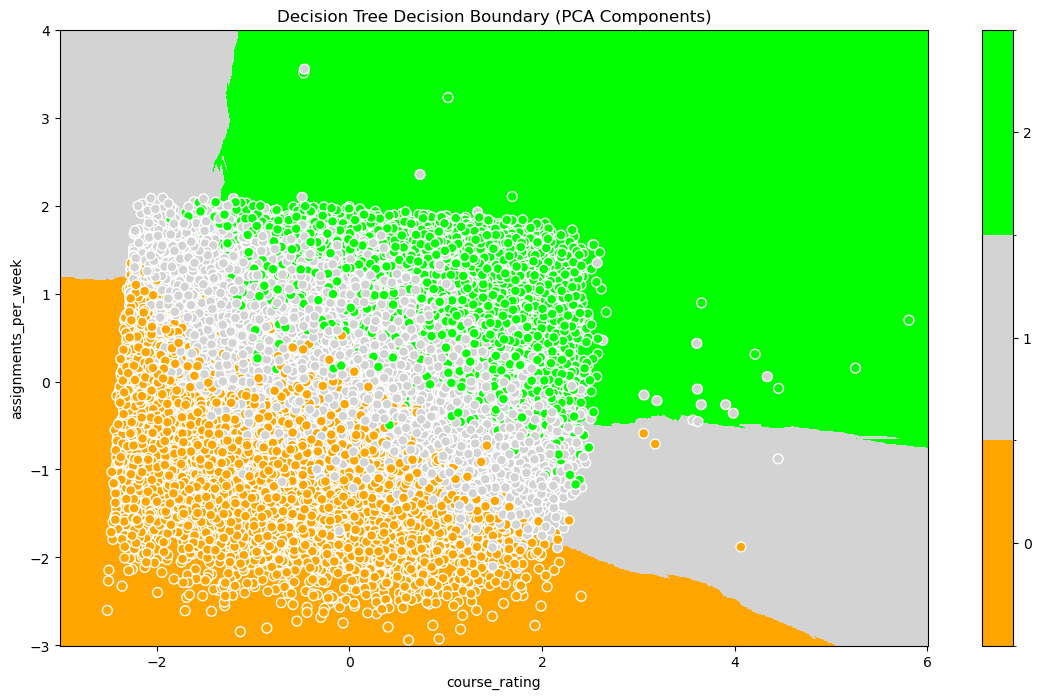

In [140]:
plot_decision_regions(X_train, y_train, estimator=best_knn,
                      x1=0, x2=1,
                      title="Decision Tree Decision Boundary (PCA Components)",
                      my_cmap=cmap_clear)


# Iteration 2: Decision Trees

Best Decision Tree parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 5}
Grid Search Results:


param_max_depth  param_min_samples_split param_criterion  mean_test_score  \
0                3                        2            gini         0.723619   
1                3                        5            gini         0.723619   
2                3                       10            gini         0.723619   
3                5                        2            gini         0.755680   
4                5                        5            gini         0.755680   
5                5                       10            gini         0.755680   
6                8                        2            gini         0.767899   
7                8                        5            gini         0.767899   
8                8                       10            gini         0.767873   
9             None                        2            gini         0.692214   
10            None                        5            gini         0.695269   
11            None                       10            gini         0.703928   
12               3                        2         entropy         0.708775   
13               3                        5         entropy         0.708775   
14               3                       10         entropy         0.708775   
15               5                        2         entropy         0.754872   
16               5                        5         entropy         0.754872   
17               5                       10         entropy         0.754872   
18               8                        2         entropy         0.768757   
19               8                        5         entropy         0.768807   
20               8                       10         entropy         0.768807   
21            None                        2         entropy         0.690422   
22            None                        5         entropy         0.691255   
23            None                       10         entropy         0.701202   

    std_test_score  
0         0.005484  
1         0.005484  
2         0.005484  
3         0.007707  
4         0.007707  
5         0.007707  
6         0.004748  
7         0.004696  
8         0.004764  
9         0.005355  
10        0.004765  
11        0.006308  
12        0.007009  
13        0.007009  
14        0.007009  
15        0.005949  
16        0.005949  
17        0.005949  
18        0.003779  
19        0.003772  
20        0.003772  
21        0.004507  
22        0.004773  
23        0.007674


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.77      0.80      2971
           1       0.74      0.82      0.78      4949
           2       0.74      0.62      0.68      1984

    accuracy                           0.77      9904
   macro avg       0.77      0.74      0.75      9904
weighted avg       0.77      0.77      0.76      9904



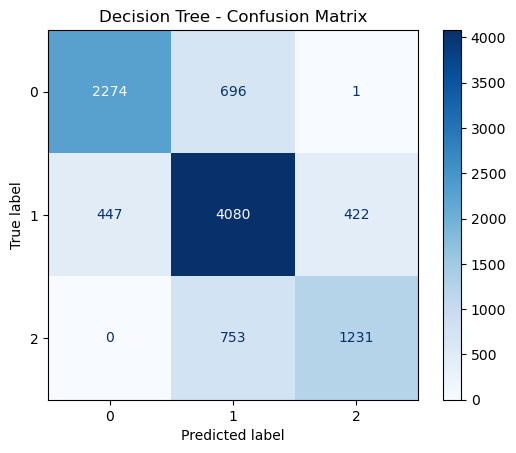

In [142]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Parameters to test
param_grid = {
    'max_depth': [3, 5, 8, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

tree_clf = DecisionTreeClassifier(random_state=42)
grid_tree = GridSearchCV(tree_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_tree.fit(X_train, y_train)

# Best model
best_tree = grid_tree.best_estimator_
print("Best Decision Tree parameters:", grid_tree.best_params_)

results_df = pd.DataFrame(grid_tree.cv_results_)
print("Grid Search Results:")
display(results_df[['param_max_depth', 'param_min_samples_split', 'param_criterion', 'mean_test_score', 'std_test_score']])


# Evaluate on test set
y_pred_tree = best_tree.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_tree))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_tree, X_test, y_test, display_labels=le.classes_, cmap='Blues')
plt.title("Decision Tree - Confusion Matrix")
plt.show()


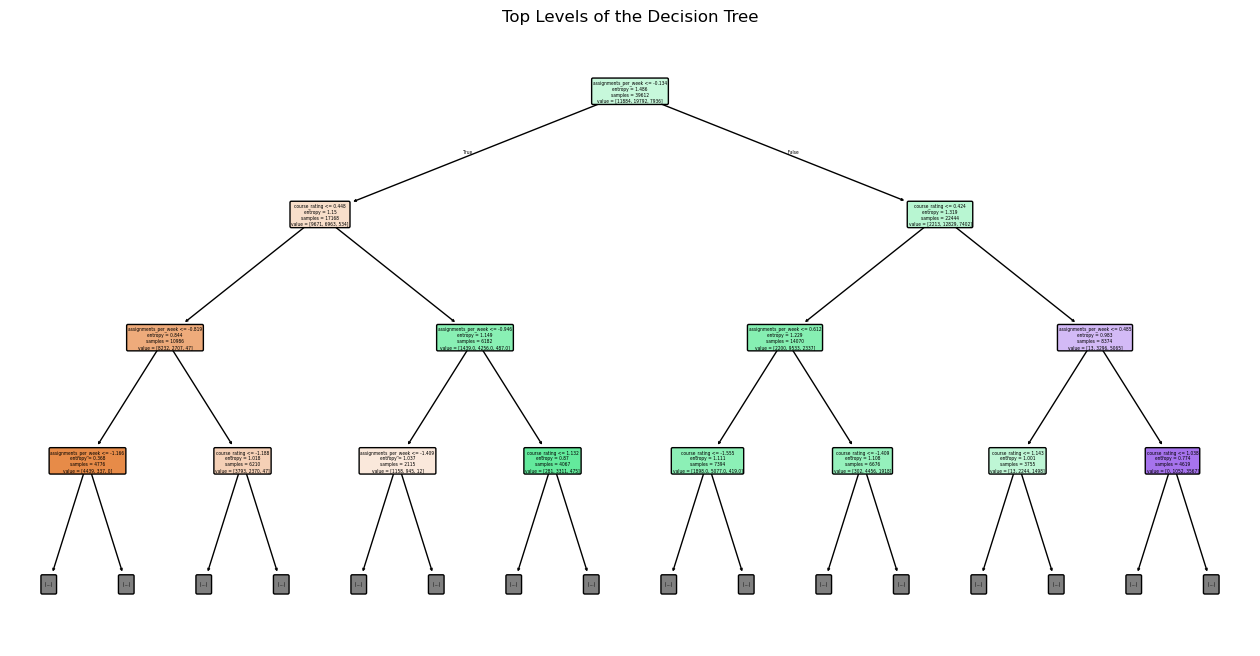

In [143]:
plt.figure(figsize=(16, 8))
plot_tree(best_tree, feature_names=X.columns, filled=True, rounded=True, max_depth=3)
plt.title("Top Levels of the Decision Tree")
plt.show()

In [144]:
#Create a custom color map
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'blue'])
cmap_clear = ListedColormap(['orange', 'lightgray', 'lime'])
cmap_two_clear = ListedColormap(['orange', 'lime'])

# to plot a colorbar, kinda convoluted here!
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_decision_regions(X, Y, estimator, x1=0, x2=1, title='',
                          my_cmap=cmap_clear, size=(14,8), data=True, clf=True):
    '''
    X: Array of (all) feature data 
    Y: Array of labels
    estimator: classifier (e.g., DT) or regressor trained on the feature pair (x1, x2)
    x1, x2: integers, index of the two features selected for plotting the decision region
    title: title of the plot (e.g., it might include the accuracy of the classifier)
    my_cmap: the colormap used to display label colors
    size: size of the figure, in matplotlib
    data: if True, the traiuning datapoints are shown together with the decision regions
    clf: if True, estimator is a classifier, a regressor otherwise
    '''
    
    # get feature ranges for creating a meshgrid
    feature_ranges = np.array([ (np.floor(np.min(X[:, i])), 
                                 np.ceil(np.max(X[:, i]))) 
                                 for i in [x1, x2]]  )

    num_of_pts = 1000
    
    # a meshgrid of values for (f1, f2), these are the points where 
    # algorithm will be queried and that we want to visualize
    xx, yy = np.meshgrid( np.linspace(feature_ranges[0, 0],
                                      feature_ranges[0, 1], 
                                      num=num_of_pts),
                          np.linspace(feature_ranges[1, 0],
                                      feature_ranges[1, 1], 
                                      num=num_of_pts))
    #print(xx.shape, yy.shape)

    # get the labels of all the points in the meshgrid
    labels_mesh = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # reshape the array to be of the same dimesion as xx and yy
    labels_mesh = labels_mesh.reshape(xx.shape)

    #print(np.c_[xx.ravel(), yy.ravel()].shape, labels_mesh.shape)

    plt.figure(figsize=size)
    plt.title(title)

    # the color map automatically assigns a different color to the 
    # different values of labels / cluster 
    plt.pcolormesh(xx, yy, labels_mesh, cmap=my_cmap)

    # Add the original data points 
    if data == True:
        scatter = plt.scatter(X[:, x1], X[:, x2], c=Y, s=50, edgecolor='white', cmap=my_cmap)
        #plt.colorbar(scatter)

    # plot a colorbar, kinda convoluted here!
    # Get current axis
    ax = plt.gca()

    # check if classification or regression
    if clf == True:
        # Create a colorbar with labels
        labels = np.unique(Y.values if hasattr(Y, "values") else Y)
        n_classes = len(labels)

        norm = BoundaryNorm(boundaries=np.arange(n_classes+1)-0.5, ncolors=n_classes)

        # Create a ScalarMappable for the colorbar
        sm = ScalarMappable(cmap=my_cmap, norm=norm)
        sm.set_array([])  # Required for some versions

        # Add the colorbar
        cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(n_classes))
        cbar.set_ticklabels(labels)
    else:
        # Regression: use a continuous colormap (!!) and automatic scaling
        sm = plt.cm.ScalarMappable(cmap=my_cmap)
        sm.set_array(Y.values if hasattr(Y, "values") else Y)

        # Attach the colorbar to current axis
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label("Predicted value")  # Optional
        
    plt.xlabel(str(x1))
    plt.ylabel(str(x2))
        
    plt.show()

In [145]:
df

course_rating  assignments_per_week  attendance_required  \
0           0.235294             -0.333333                 -1.0   
1          -0.352941              1.000000                  0.0   
2          -0.764706              0.666667                  0.0   
3          -0.411765              0.333333                  0.0   
4           0.411765              0.000000                 -1.0   
...              ...                   ...                  ...   
49511      -0.176471             -0.333333                 -1.0   
49512       0.411765             -0.666667                  0.0   
49513       1.588235              0.333333                  0.0   
49514       0.411765              0.000000                  0.0   
49515      -0.764706             -0.333333                  0.0   

       sentiment_score  units  hours_per_week  projects  midterms_count  \
0             1.158416   -1.0            -1.2      -1.0            -0.5   
1            -0.584158    0.0             0.8       0.0            -0.5   
2            -0.564356    0.0             0.2      -1.0             0.0   
3            -0.534653   -1.0            -0.4       0.0            -0.5   
4             0.435644    0.0             0.2      -1.0             0.5   
...                ...    ...             ...       ...             ...   
49511         0.000000   -1.0            -0.8      -1.0            -0.5   
49512         0.495050   -0.5             2.2       0.0             0.0   
49513        -0.693069    0.5             1.2       0.0             0.5   
49514         0.297030   -1.0             2.2       0.0             0.0   
49515        -0.198020   -0.5            -0.2      -1.0             0.0   

       final_exam  grading_strictness  failure_rate  difficulty_level_num  \
0             0.0               -0.20      0.615385                     0   
1            -1.0               -0.50     -0.461538                     2   
2            -1.0               -0.70     -0.153846                     1   
3             0.0               -0.05     -0.076923                     1   
4            -1.0               -0.15      0.615385                     1   
...           ...                 ...           ...                   ...   
49511         0.0                1.00      0.307692                     1   
49512         0.0                0.00     -1.230769                     1   
49513         0.0                0.25     -1.615385                     1   
49514         0.0                0.00     -0.461538                     2   
49515         0.0                0.50     -0.461538                     2   

       subject_area_Humanities  subject_area_STEM  \
0                        False               True   
1                        False               True   
2                         True              False   
3                        False              False   
4                        False              False   
...                        ...                ...   
49511                     True              False   
49512                    False               True   
49513                    False               True   
49514                    False              False   
49515                    False               True   

       subject_area_Social Science  effort_score  
0                            False     -1.382353  
1                            False      0.470588  
2                            False      0.176471  
3                             True     -0.764706  
4                             True      0.235294  
...                            ...           ...  
49511                        False     -1.205882  
49512                        False      0.735294  
49513                        False      1.281355  
49514                         True      0.500000  
49515                        False     -0.411765  

[49516 rows x 16 columns]

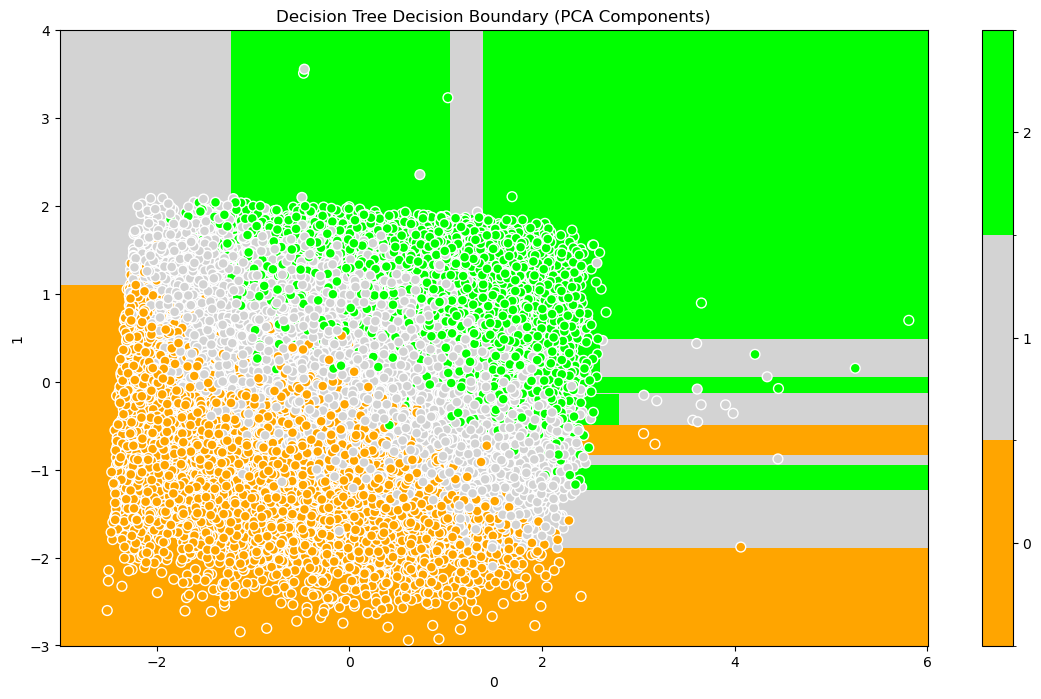

In [146]:
plot_decision_regions(X_train, y_train, estimator=best_tree,
                      x1=0, x2=1,
                      title="Decision Tree Decision Boundary (PCA Components)",
                      my_cmap=cmap_clear)


# Training bagging

In [148]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Base estimator
base_estimator = DecisionTreeClassifier(random_state=42)

# Define Bagging parameter grid
param_grid_bagging = {
    'n_estimators': [10, 30, 50],         # Number of estimators
    'max_samples': [0.2, 0.5, 0.8, 1.0],  # Fraction of training samples per estimator
    'max_features': [0.5, 0.8, 1.0],      # Fraction of features per estimator
    'bootstrap': [True, False]             # With or without replacement
}

# Initialize Bagging Classifier
bagging = BaggingClassifier(
    estimator=base_estimator,
    n_jobs=-1,
    random_state=42
)

# Setup Grid Search
grid_search_bagging = GridSearchCV(
    estimator=bagging,
    param_grid=param_grid_bagging,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

# Fit
grid_search_bagging.fit(X_train, y_train)


# Best Bagging model
best_bagging = grid_search_bagging.best_estimator_
print("Best Bagging Parameters:", grid_search_bagging.best_params_)

# Predict
y_pred_bagging = best_bagging.predict(X_test)

# Evaluation
print("\nClassification Report for Best Bagging Model:\n")
print(classification_report(y_test, y_pred_bagging))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Bagging Parameters: {'bootstrap': True, 'max_features': 1.0, 'max_samples': 0.2, 'n_estimators': 50}

Classification Report for Best Bagging Model:

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      2971
           1       0.74      0.81      0.78      4949
           2       0.75      0.60      0.67      1984

    accuracy                           0.76      9904
   macro avg       0.77      0.74      0.75      9904
weighted avg       0.77      0.76      0.76      9904



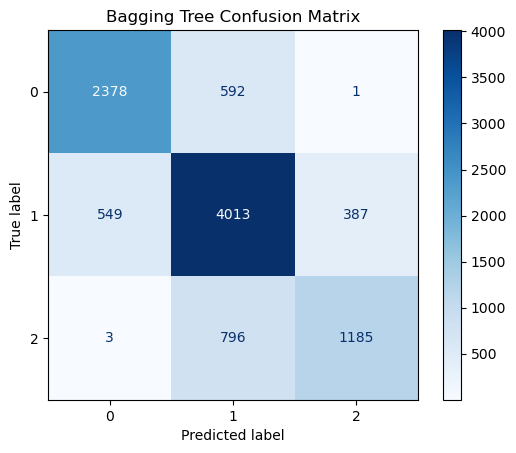

In [149]:
ConfusionMatrixDisplay.from_estimator(best_bagging, X_test, y_test, cmap='Blues')
plt.title("Bagging Tree Confusion Matrix")
plt.show()

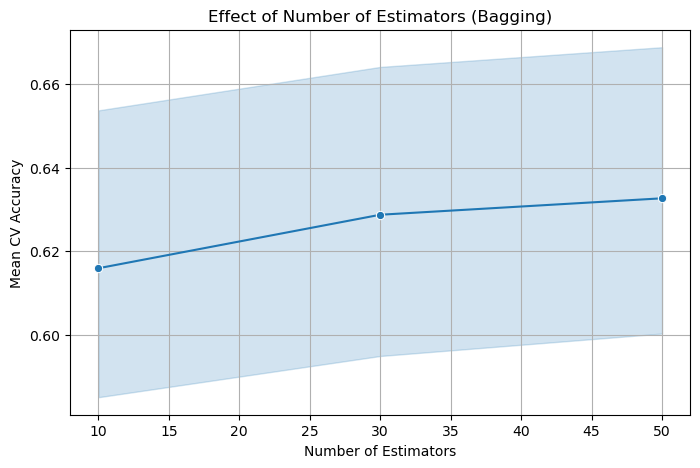

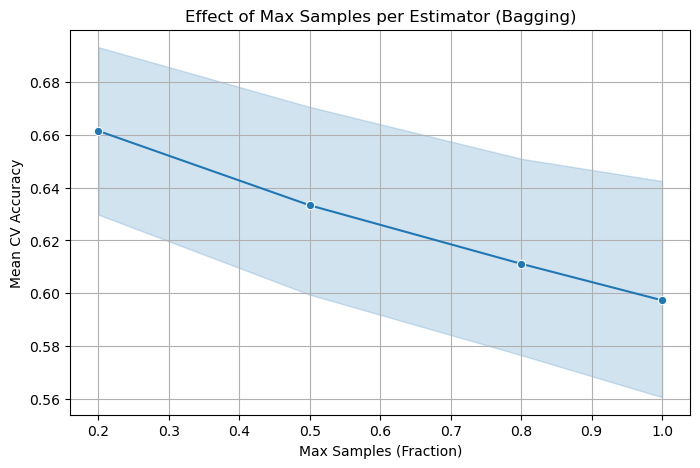

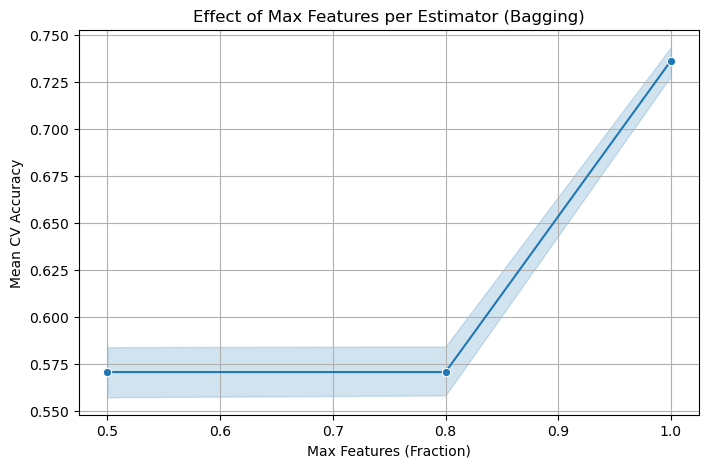

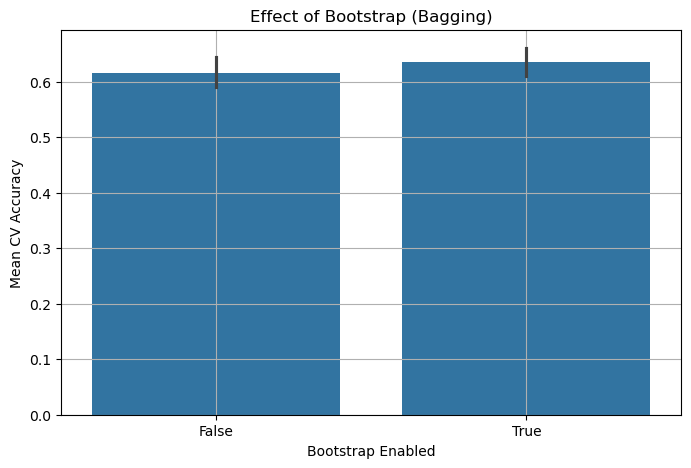

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you already have
results_bagging = pd.DataFrame(grid_search_bagging.cv_results_)

# 1. Plot n_estimators vs accuracy
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_bagging, x='param_n_estimators', y='mean_test_score', marker='o')
plt.title("Effect of Number of Estimators (Bagging)")
plt.xlabel("Number of Estimators")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()

# 2. Plot max_samples vs accuracy
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_bagging, x='param_max_samples', y='mean_test_score', marker='o')
plt.title("Effect of Max Samples per Estimator (Bagging)")
plt.xlabel("Max Samples (Fraction)")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()

# 3. Plot max_features vs accuracy
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_bagging, x='param_max_features', y='mean_test_score', marker='o')
plt.title("Effect of Max Features per Estimator (Bagging)")
plt.xlabel("Max Features (Fraction)")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()

# 4. Plot bootstrap vs accuracy
plt.figure(figsize=(8, 5))
sns.barplot(data=results_bagging, x='param_bootstrap', y='mean_test_score')
plt.title("Effect of Bootstrap (Bagging)")
plt.xlabel("Bootstrap Enabled")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()

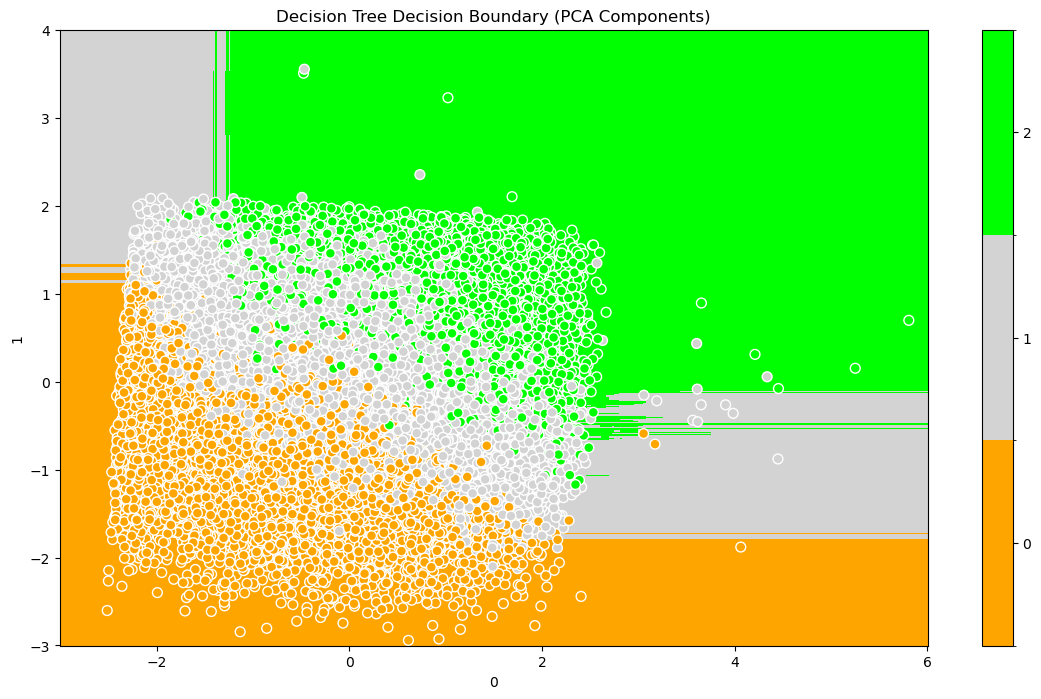

In [151]:
plot_decision_regions(X_train, y_train, estimator=best_bagging,
                      x1=0, x2=1,
                      title="Decision Tree Decision Boundary (PCA Components)",
                      my_cmap=cmap_clear)


# Training random forest

In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees
    'max_depth': [5, 10, 20, 30, 40],        # Depth of each tree
    'max_features': ['sqrt', 'log2'],      # Features considered per split
    'bootstrap': [True, False],            # Bagging with or without replacement
    'criterion': ['gini', 'entropy']       # Split criteria
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Setup Grid Search
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

# Fit the model
grid_search_rf.fit(X_train, y_train)


# Best model
best_rf = grid_search_rf.best_estimator_
print("Best Random Forest Parameters:", grid_search_rf.best_params_)

# Predict
y_pred_rf = best_rf.predict(X_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Random Forest Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}


In [154]:
# Evaluation
print("\nClassification Report for Best RF Model:\n")
print(classification_report(y_test, y_pred_rf))


Classification Report for Best RF Model:

              precision    recall  f1-score   support

           0       0.82      0.79      0.81      2971
           1       0.74      0.83      0.78      4949
           2       0.78      0.59      0.67      1984

    accuracy                           0.77      9904
   macro avg       0.78      0.74      0.75      9904
weighted avg       0.77      0.77      0.77      9904



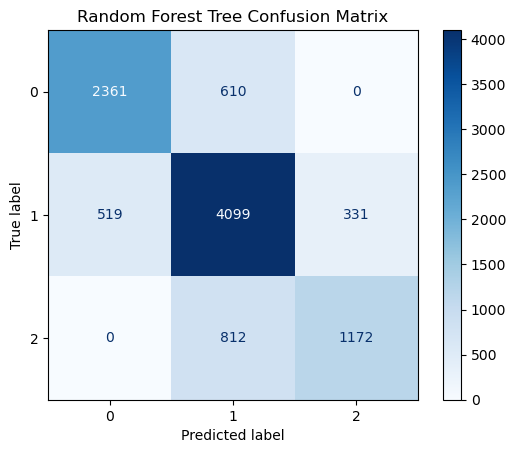

In [155]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap='Blues')
plt.title("Random Forest Tree Confusion Matrix")
plt.show()

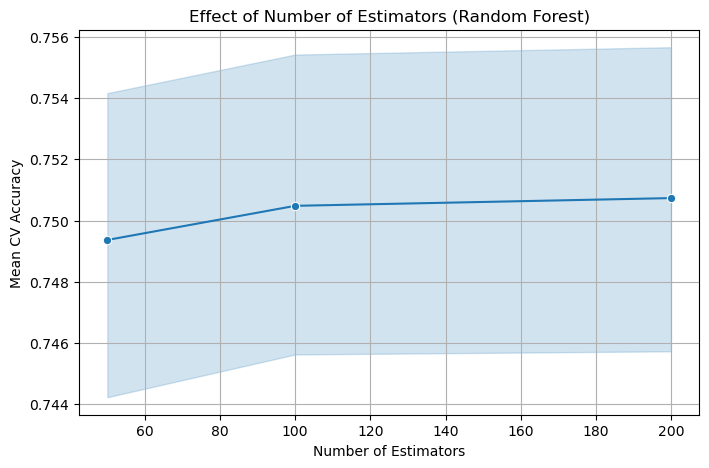

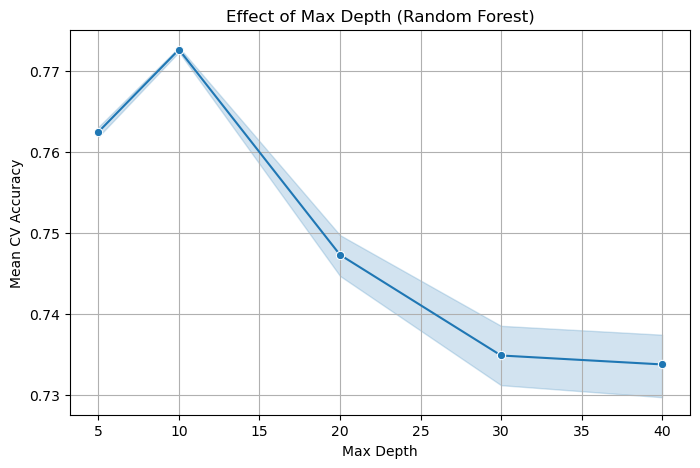

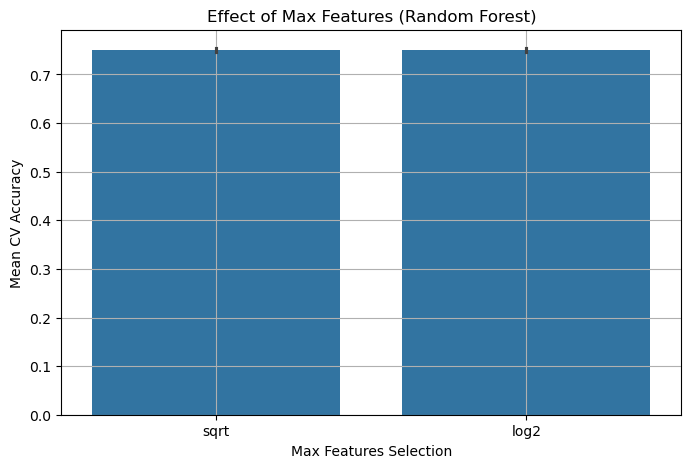

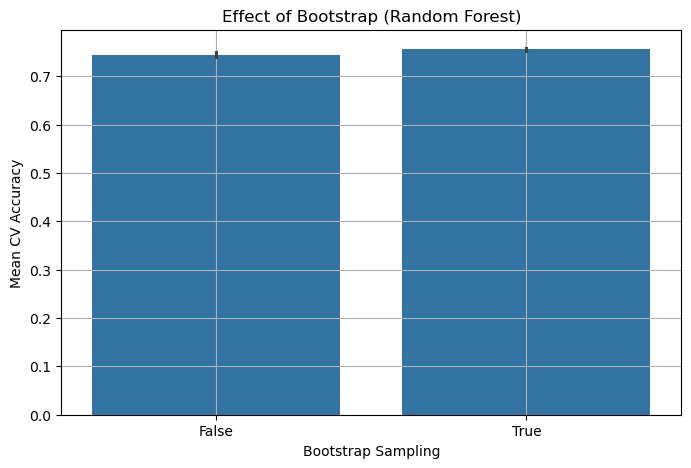

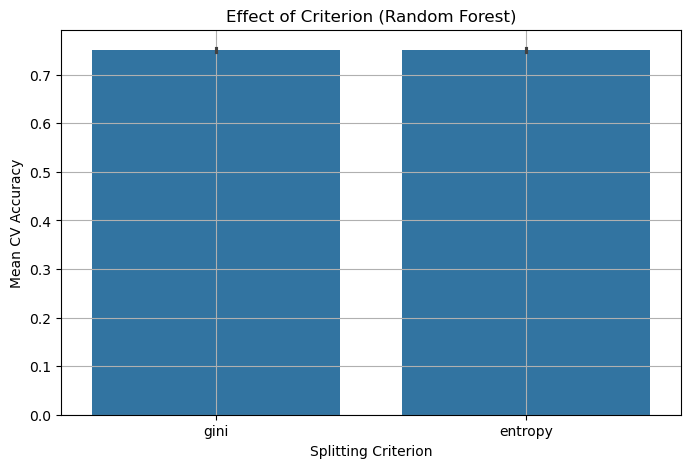

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you already have
# results_rf = pd.DataFrame(grid_search_rf.cv_results_)

results_rf = pd.DataFrame(grid_search_rf.cv_results_)

# 1. Plot n_estimators vs accuracy
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_rf, x='param_n_estimators', y='mean_test_score', marker='o')
plt.title("Effect of Number of Estimators (Random Forest)")
plt.xlabel("Number of Estimators")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()

# 2. Plot max_depth vs accuracy
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_rf, x='param_max_depth', y='mean_test_score', marker='o')
plt.title("Effect of Max Depth (Random Forest)")
plt.xlabel("Max Depth")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()

# 3. Plot max_features vs accuracy
plt.figure(figsize=(8, 5))
sns.barplot(data=results_rf, x='param_max_features', y='mean_test_score')
plt.title("Effect of Max Features (Random Forest)")
plt.xlabel("Max Features Selection")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()

# 4. Plot bootstrap vs accuracy
plt.figure(figsize=(8, 5))
sns.barplot(data=results_rf, x='param_bootstrap', y='mean_test_score')
plt.title("Effect of Bootstrap (Random Forest)")
plt.xlabel("Bootstrap Sampling")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()

# 5. Plot criterion vs accuracy
plt.figure(figsize=(8, 5))
sns.barplot(data=results_rf, x='param_criterion', y='mean_test_score')
plt.title("Effect of Criterion (Random Forest)")
plt.xlabel("Splitting Criterion")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()



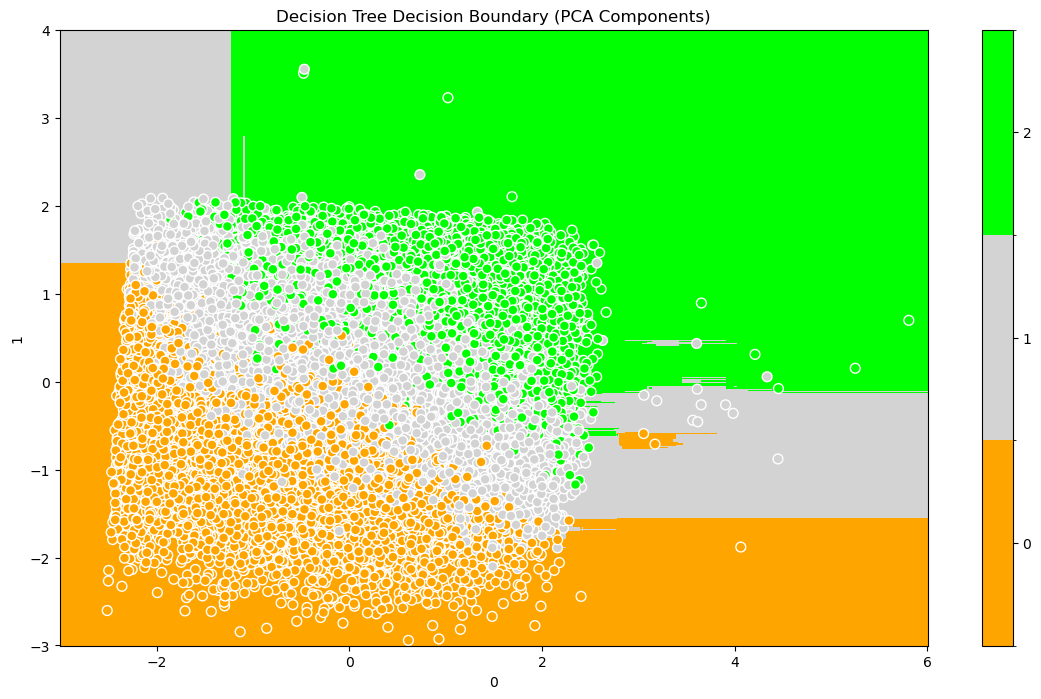

In [157]:
plot_decision_regions(X_train, y_train, estimator=best_rf,
                      x1=0, x2=1,
                      title="Decision Tree Decision Boundary (PCA Components)",
                      my_cmap=cmap_clear)


# Iteration 3: Support Vector Machines (SVMs)


In this iteration, we move towards **margin-based learning methods** by experimenting with **Support Vector Machines (SVMs)**. SVMs are powerful classifiers that find the optimal decision boundary by maximizing the margin between classes.


We explore three variations:
- **Linear SVM**: Tests if the data is linearly separable.
- **RBF (Gaussian Kernel) SVM**: Allows flexible, curved boundaries for nonlinear separability.
- **Polynomial Kernel SVM**: Captures more complex, higher-order interactions.

Each kernel increases model complexity progressively. This strategy allows us to systematically understand how model flexibility affects performance after simpler models (KNN, Decision Tree).

We apply cross-validation to tune hyperparameters and evaluate using classification reports and confusion matrices.


## Linea SVM

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Linear SVM Grid
param_grid_linear = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear']
}

svm_linear = SVC()
grid_linear = GridSearchCV(svm_linear, param_grid_linear, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_linear.fit(X_train, y_train)

best_linear = grid_linear.best_estimator_
print("Best Linear SVM Parameters:", grid_linear.best_params_)

# Evaluate
y_pred_linear = best_linear.predict(X_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Linear SVM Parameters: {'C': 0.01, 'kernel': 'linear'}



Linear SVM Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      2971
           1       0.74      0.83      0.78      4949
           2       0.77      0.59      0.67      1984

    accuracy                           0.77      9904
   macro avg       0.78      0.73      0.75      9904
weighted avg       0.77      0.77      0.76      9904



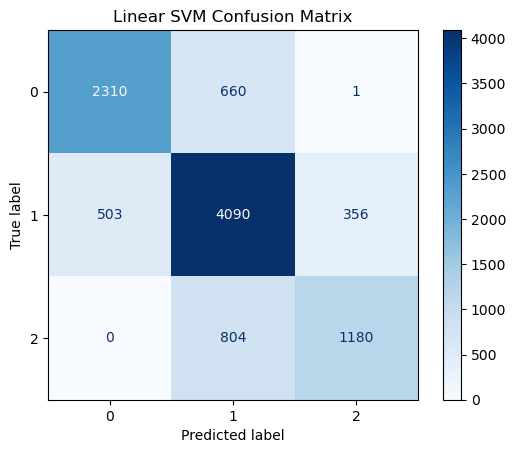

In [6]:
print("\nLinear SVM Classification Report:\n")
print(classification_report(y_test, y_pred_linear))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_linear, X_test, y_test, cmap='Blues')
plt.title("Linear SVM Confusion Matrix")
plt.show()

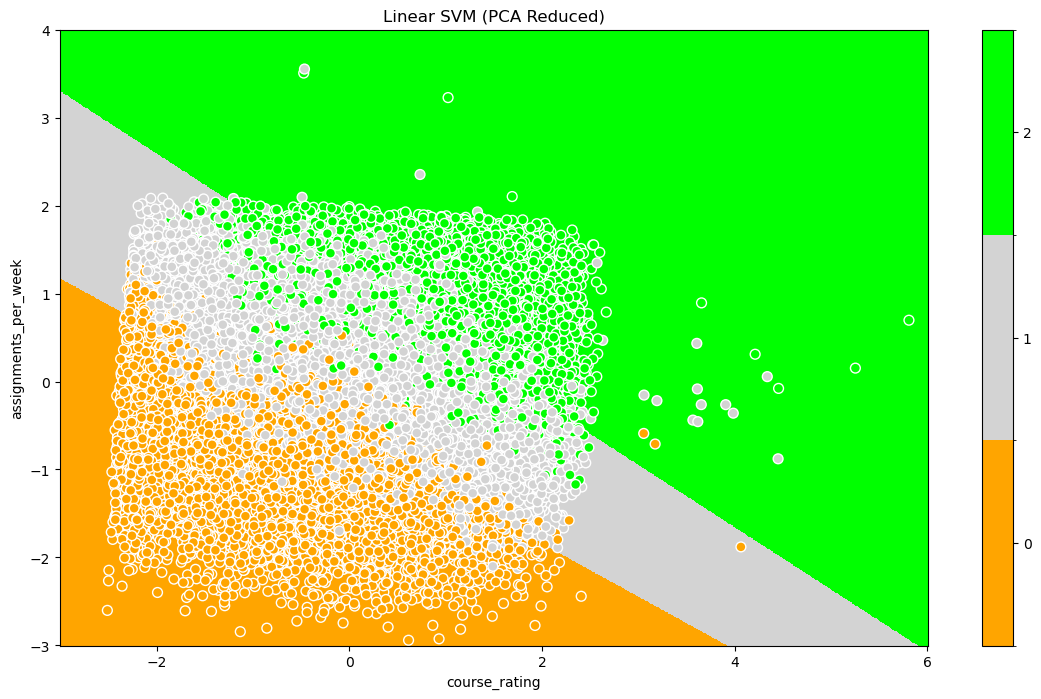

In [22]:
plot_decision_regions(X_train, y_train,
                      estimator=best_linear,
                      title="Linear SVM (PCA Reduced)",
                      my_cmap=cmap_clear)

In [23]:
# RBF SVM Grid
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

svm_rbf = SVC()
grid_rbf = GridSearchCV(svm_rbf, param_grid_rbf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_rbf.fit(X_train, y_train)

best_rbf = grid_rbf.best_estimator_
print("Best RBF SVM Parameters:", grid_rbf.best_params_)

# Evaluate
y_pred_rbf = best_rbf.predict(X_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best RBF SVM Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}



RBF SVM Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.78      0.80      2971
           1       0.74      0.85      0.79      4949
           2       0.81      0.57      0.67      1984

    accuracy                           0.77      9904
   macro avg       0.79      0.73      0.75      9904
weighted avg       0.78      0.77      0.77      9904



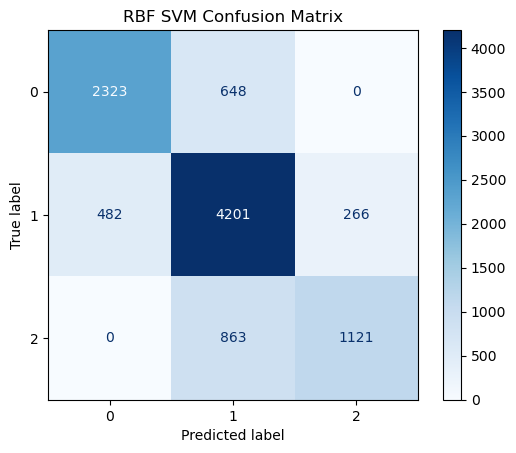

In [24]:
print("\nRBF SVM Classification Report:\n")
print(classification_report(y_test, y_pred_rbf))

ConfusionMatrixDisplay.from_estimator(best_rbf, X_test, y_test, cmap='Blues')
plt.title("RBF SVM Confusion Matrix")
plt.show()

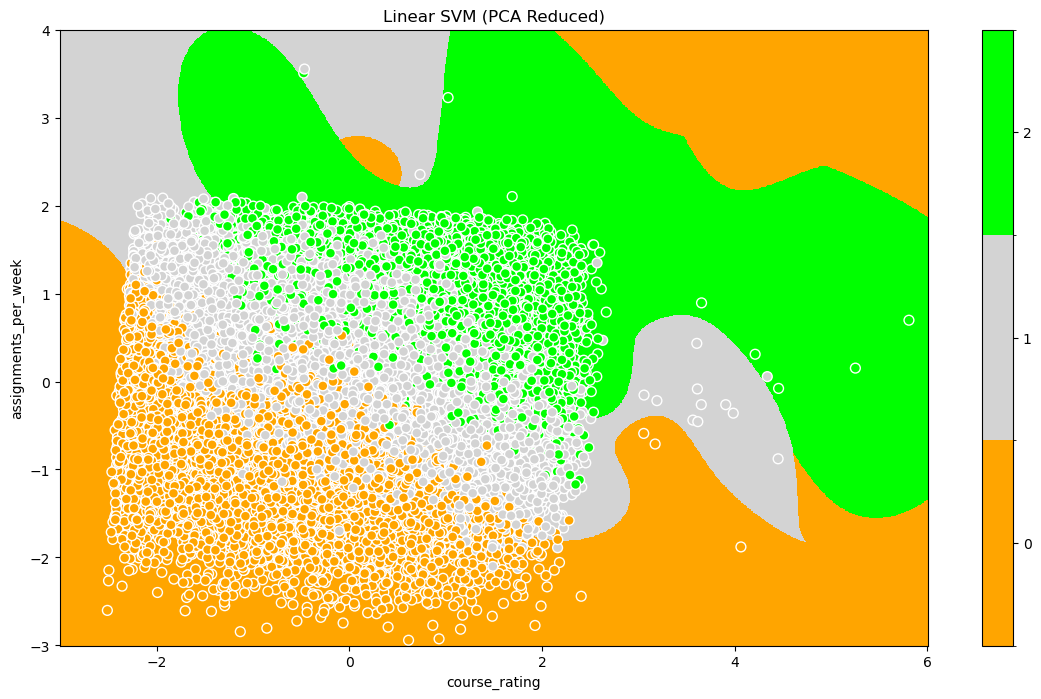

In [25]:
plot_decision_regions(X_train, y_train,
                      estimator=best_rbf,
                      title="Linear SVM (PCA Reduced)",
                      my_cmap=cmap_clear)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Polynomial SVM Parameters: {'C': 0.1, 'coef0': 1, 'degree': 4, 'kernel': 'poly'}

Polynomial SVM Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.75      0.79      2971
           1       0.72      0.87      0.79      4949
           2       0.82      0.54      0.65      1984

    accuracy                           0.77      9904
   macro avg       0.80      0.72      0.74      9904
weighted avg       0.78      0.77      0.76      9904



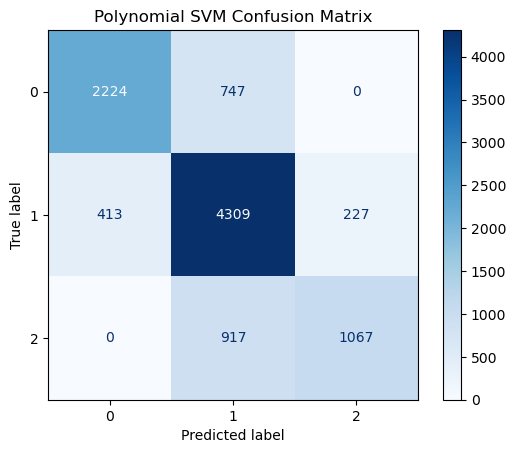

In [26]:
# Polynomial SVM Grid
param_grid_poly = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'coef0': [0, 1],
    'kernel': ['poly']
}

svm_poly = SVC()
grid_poly = GridSearchCV(svm_poly, param_grid_poly, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_poly.fit(X_train, y_train)

best_poly = grid_poly.best_estimator_
print("Best Polynomial SVM Parameters:", grid_poly.best_params_)

# Evaluate
y_pred_poly = best_poly.predict(X_test)
print("\nPolynomial SVM Classification Report:\n")
print(classification_report(y_test, y_pred_poly))

ConfusionMatrixDisplay.from_estimator(best_poly, X_test, y_test, cmap='Blues')
plt.title("Polynomial SVM Confusion Matrix")
plt.show()

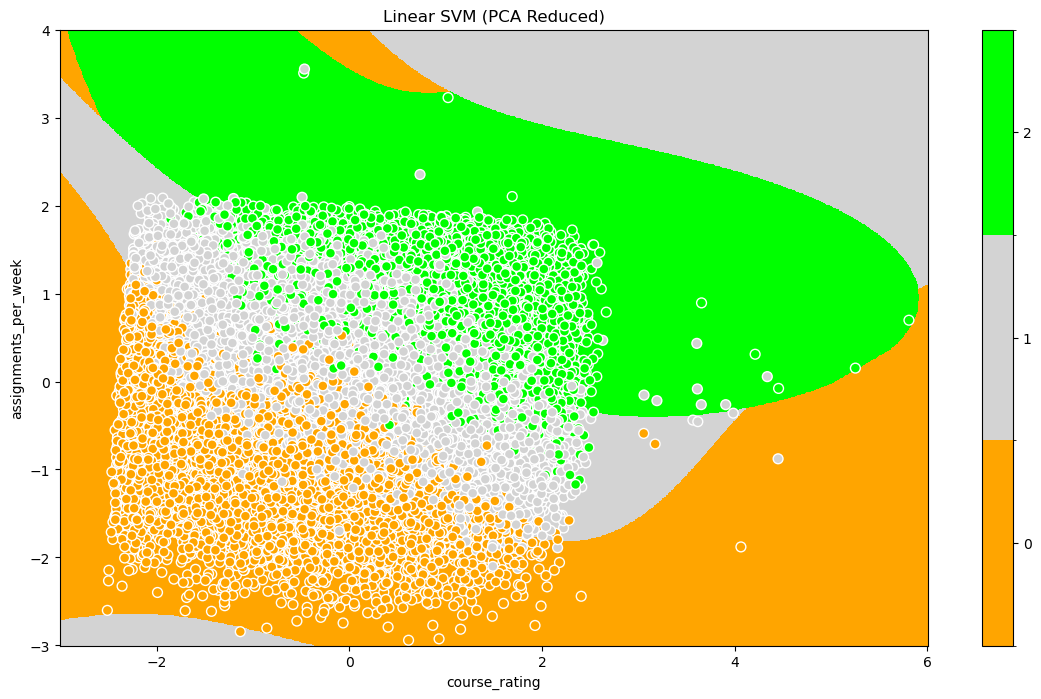

In [21]:
plot_decision_regions(X_train, y_train,
                      estimator=best_poly,
                      title="Linear SVM (PCA Reduced)",
                      my_cmap=cmap_clear)

### Lessons Learned

Support Vector Machines provided a strong final iteration, showing better generalization on complex boundaries compared to KNN and Decision Trees.

- **Linear SVM** performed decently when the data was relatively separable but struggled in overlap regions.
- **RBF SVM** improved significantly by adapting flexible boundaries, achieving higher overall accuracy.
- **Polynomial SVM** captured even complex patterns but risked overfitting when degree was too high.

Cross-validation results confirmed that hyperparameters like `C` and `gamma` heavily influence model flexibility.

SVMs demonstrate that margin maximization is a robust approach, especially when nonlinearity is present. However, they require careful tuning to avoid overfitting on complex datasets.


In [170]:
import joblib

# Save trained best model
joblib.dump(best_rbf, 'best_model.pkl')  

# Save scaler if you used it
joblib.dump(scaler, 'scaler.pkl')

# Save PCA if you used it
joblib.dump(pca, 'pca.pkl')


['best_model.pkl']

In [174]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [176]:

joblib.dump(pca, 'pca.pkl')

['pca.pkl']